In [181]:
# Importing modules
import pandas as pd
import numpy as np

data = pd.read_csv('netflix_titles.csv')# Print head
data.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [182]:
# Load the regular expression library
import re

# Remove punctuation
data['description_processed'] = \
data['description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
data['description_processed'] = \
data['description_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
data['description_processed'].head()

0    as her father nears the end of his life filmma...
1    after crossing paths at a party a cape town te...
2    to protect his family from a powerful drug lor...
3    feuds flirtations and toilet talk go down amon...
4    in a city of coaching centers known to train i...
Name: description_processed, dtype: object

In [183]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(data['description_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [184]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

stop_words = stopwords.words('english')
stop_words.extend(['life', 'world', 'family', 'friends', 'new', 'series', 'home', 'woman', 'young', 'school', 'love', 'high', 'two', 'help', 'get', 'three', 'one', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'black', 'must', 'mother', 'friend', 'finds', 'boy', 'four', 'man', 'series', 'live', 'lives', 'father'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

description_data = data.description_processed.values.tolist()
data_words = list(sent_to_words(description_data))

# remove stop words
data_words = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

num_topics_list = list(range(51)[1:])
num_keywords = 15


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rongeryang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

## LDA

In [45]:
lda_models = {}
lda_topics = {}
coherence_lda_list = []
perplexity_lda_list = []

for num_topics in num_topics_list:
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
    lda_models[num_topics] = lda_model
    
    #calculating model perplexity
    perplexity_lda_list.append(lda_model.log_perplexity(corpus))
    
    # Compute Coherence Score
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, 
                                         coherence='c_v', texts = texts)
    coherence_lda_list.append(coherence_model_lda.get_coherence())
    
    shown_topics = lda_model.show_topics(num_topics=num_topics, 
                                             num_words=15,
                                             formatted=False)
    lda_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    print('num_topics:', num_topics, 'coherence lda:', coherence_lda_list[num_topics - 1], 'perplexity lda:', perplexity_lda_list[num_topics - 1])
    
    

num_topics: 1 coherence lda: 0.1986213963580871 perplexity lda: -8.923919694324258
num_topics: 2 coherence lda: 0.18622418656753137 perplexity lda: -9.095841577637172
num_topics: 3 coherence lda: 0.20674253732106593 perplexity lda: -9.200291155896101
num_topics: 4 coherence lda: 0.20656849306059133 perplexity lda: -9.272632429416175
num_topics: 5 coherence lda: 0.1930584244849654 perplexity lda: -9.333885112719187
num_topics: 6 coherence lda: 0.19056655692759616 perplexity lda: -9.39686316645307
num_topics: 7 coherence lda: 0.17387342745624434 perplexity lda: -9.447211596288167
num_topics: 8 coherence lda: 0.20117199469281213 perplexity lda: -9.495336842903388
num_topics: 9 coherence lda: 0.20188008094800683 perplexity lda: -9.54203077347685
num_topics: 10 coherence lda: 0.20763704840893377 perplexity lda: -9.581105144664619
num_topics: 11 coherence lda: 0.1965516622306402 perplexity lda: -9.62272107296154
num_topics: 12 coherence lda: 0.20831387664402837 perplexity lda: -9.65992356489

In [46]:
import matplotlib.pyplot as plt 

plt.plot(num_topics_list, perplexity_lda_list, label='Perplexity')
plt.plot(num_topics_list, coherence_lda_list, label='Coherence')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.legend()
plt.show()

In [81]:
lda_stability = {}
for i in range(0, len(num_topics_list)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(lda_topics[num_topics_list[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(lda_topics[num_topics_list[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    lda_stability[num_topics_list[i]] = jaccard_sims
                
mean_stabilities = [np.array(lda_stability[i]).mean() for i in num_topics_list[:-1]]
coh_sta_diffs = [coherence_lda_list[i] - mean_stabilities[i] for i in range(num_topics_list[-1]-1)] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics_list[ideal_topic_num_index] + 1
ideal_topic_num

47

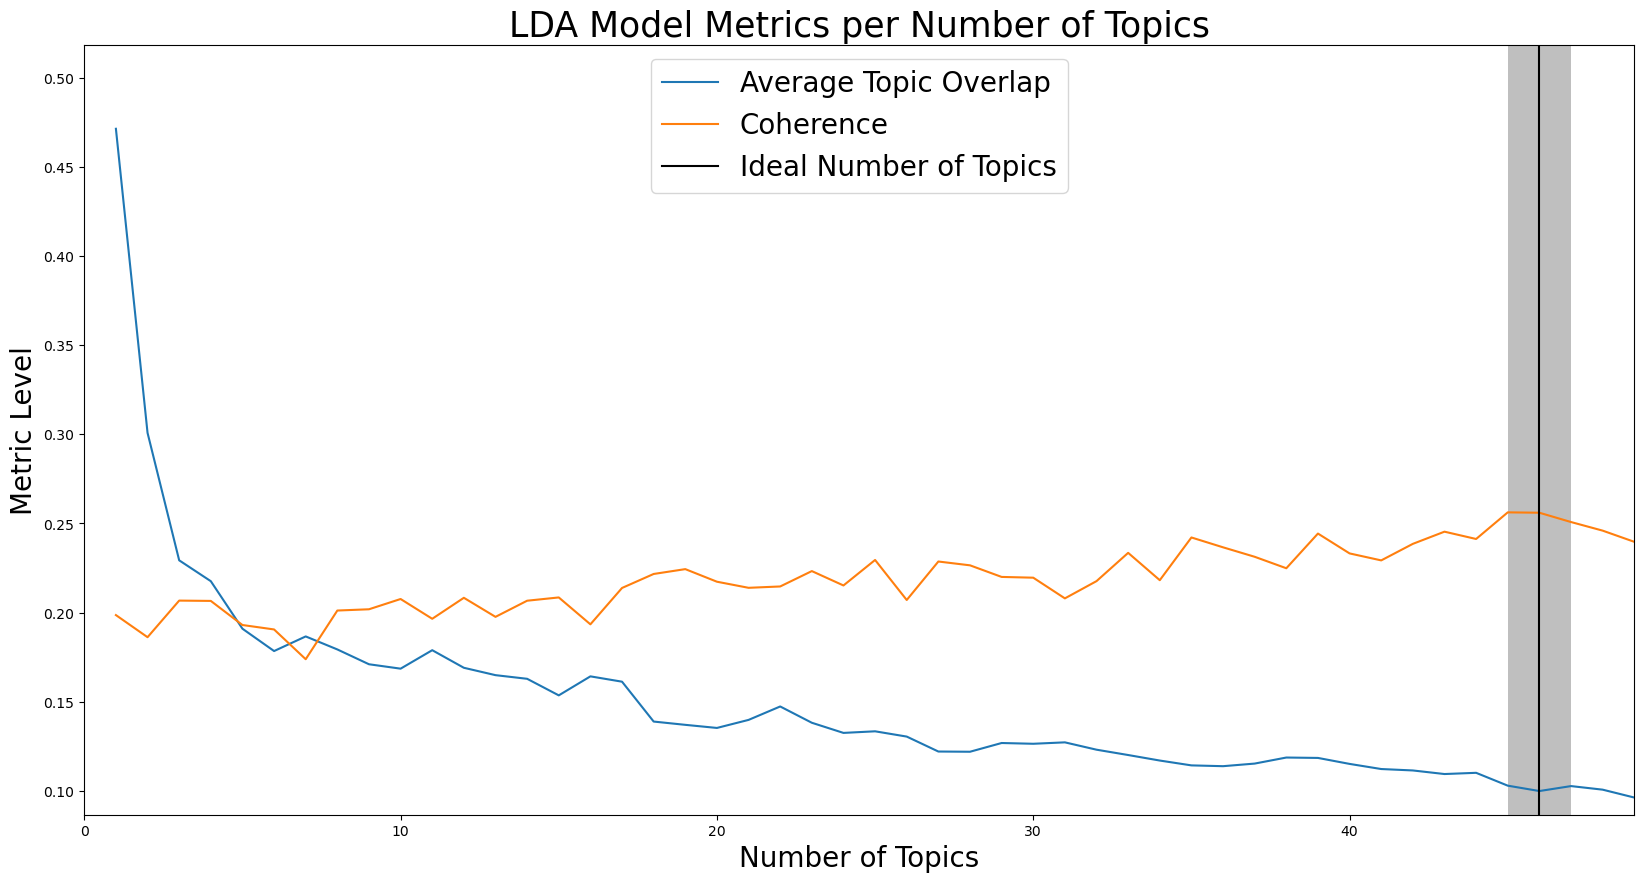

In [82]:
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics_list[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics_list[:-1], y=coherence_lda_list[:-1], label='Coherence')
# ax = sns.lineplot(x=num_topics_list[:-1], y=perplexity_lda_list[:-1], label='Perplexity')

ax.axvline(x=ideal_topic_num-1, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 2, xmax=ideal_topic_num, alpha=0.5, facecolor='grey')

y_min = min(min(mean_stabilities), min(coherence_lda_list[:-1])) - (0.10 * min(min(mean_stabilities), min(coherence_lda_list[:-1])))
y_max = max(max(mean_stabilities), max(coherence_lda_list[:-1])) + (0.10 * max(max(mean_stabilities), max(coherence_lda_list[:-1])))
ax.set_ylim([y_min, y_max])
ax.set_xlim([0, num_topics_list[-1]-1])
                
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [80]:
pip install --upgrade pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [144]:
from pprint import pprint

# Assuming best num_topics = 47
# Print the Keyword in each topics
optimal_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=47)
pprint(optimal_lda_model.print_topics(num_topics=47, num_words=15))
doc_lda = optimal_lda_model[corpus]

[(0,
  '0.004*"best" + 0.004*"takes" + 0.004*"old" + 0.004*"take" + 0.003*"story" + '
  '0.003*"year" + 0.003*"romance" + 0.003*"special" + 0.003*"film" + '
  '0.002*"fight" + 0.002*"years" + 0.002*"find" + 0.002*"documentary" + '
  '0.002*"personal" + 0.002*"professor"'),
 (1,
  '0.003*"girl" + 0.003*"save" + 0.003*"son" + 0.003*"back" + 0.003*"gets" + '
  '0.003*"wife" + 0.002*"struggles" + 0.002*"hit" + 0.002*"work" + '
  '0.002*"couple" + 0.002*"tries" + 0.002*"film" + 0.002*"reality" + '
  '0.002*"wedding" + 0.002*"meets"'),
 (2,
  '0.004*"city" + 0.004*"find" + 0.003*"childhood" + 0.003*"journey" + '
  '0.003*"son" + 0.003*"becomes" + 0.003*"first" + 0.002*"york" + 0.002*"town" '
  '+ 0.002*"daughter" + 0.002*"people" + 0.002*"group" + 0.002*"past" + '
  '0.002*"brothers" + 0.002*"night"'),
 (3,
  '0.004*"old" + 0.004*"run" + 0.003*"teen" + 0.003*"city" + 0.003*"girl" + '
  '0.003*"become" + 0.003*"find" + 0.003*"group" + 0.003*"social" + '
  '0.003*"becomes" + 0.003*"mysterious"

In [145]:
x=optimal_lda_model.show_topics(num_topics=47, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "\n"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))

0
['best', 'takes', 'old', 'take', 'story', 'year', 'romance', 'special', 'film', 'fight', 'years', 'find', 'documentary', 'personal', 'professor']
1
['girl', 'save', 'son', 'back', 'gets', 'wife', 'struggles', 'hit', 'work', 'couple', 'tries', 'film', 'reality', 'wedding', 'meets']
2
['city', 'find', 'childhood', 'journey', 'son', 'becomes', 'first', 'york', 'town', 'daughter', 'people', 'group', 'past', 'brothers', 'night']
3
['old', 'run', 'teen', 'city', 'girl', 'become', 'find', 'group', 'social', 'becomes', 'mysterious', 'child', 'secret', 'around', 'romance']
4
['takes', 'romance', 'plot', 'brings', 'save', 'documentary', 'stories', 'mission', 'behind', 'marriage', 'single', 'stage', 'trip', 'make', 'film']
5
['little', 'war', 'true', 'based', 'agent', 'fight', 'save', 'make', 'wife', 'together', 'ex', 'human', 'documentary', 'history', 'evil']
6
['old', 'save', 'story', 'documentary', 'town', 'killer', 'take', 'year', 'couple', 'way', 'true', 'girl', 'war', 'group', 'secret']
7

In [147]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(optimal_lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version inst

A lower perplexity score indicates better generalization performance.

In [148]:
# In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. 
# To extract the dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              37              0.9247   
1            1              25              0.9388   
2            2              34              0.9388   
3            3              31              0.9347   
4            4              39              0.9347   
5            5              27              0.9388   
6            6              31              0.9388   
7            7              22              0.9424   
8            8              20              0.9347   
9            9              33              0.9247   

                                            Keywords  \
0  student, murder, years, time, marriage, true, ...   
1  find, face, show, documentary, party, city, gi...   
2  back, find, past, year, old, murder, soon, bro...   
3  drama, follows, true, documentary, story, year...   
4  find, become, death, falls, save, past, work, ...   
5  takes, team, falls, accident, war, star, old, ...   
6  drama, follows, true, documentary, story, year...   
7  girl, group, find, documentary, save, takes, f...   
8  old, years, year, crime, brother, documentary,...   
9  town, crime, group, documentary, teen, small, ...   

                                                Text  
0  nears end filmmaker kirsten johnson stages dea...  
1  crossing paths party cape town teen sets prove...  
2  protect powerful drug lord skilled thief mehdi...  
3  feuds flirtations toilet talk go among incarce...  
4  city coaching centers known train india finest...  
5  arrival charismatic priest brings glorious mir...  
6  equestria divided bright eyed hero believes ea...  
7  photo shoot ghana american model slips back ti...  
8  talented batch amateur bakers face week compet...  
9  adjusting loss contends feisty bird taken gard...

## NMF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import Nmf
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

In [119]:
nmf_models = {}
nmf_topics = {}
coherence_nmf_list = []
perplexity_nmf_list = []

for num_topics in num_topics_list:
    # Build NMF model
    nmf = Nmf(
        corpus=corpus,
        num_topics=num_topics,
        id2word=id2word,
        normalize=True,
        )
    nmf_models[num_topics] = nmf
    
    # Run the coherence model to get the score
    cm = gensim.models.coherencemodel.CoherenceModel(
        corpus=corpus,
        model=nmf,
        dictionary=id2word,
        coherence='u_mass',
        texts=texts
    )
    
    coherence_nmf_list.append(cm.get_coherence())

    
    shown_topics = nmf.show_topics(num_topics=num_topics, 
                                             num_words=15,
                                             formatted=False)
    nmf_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    print('num_topics:', num_topics, 'coherence nmf:', coherence_nmf_list[num_topics - 1])
    

num_topics: 1 coherence nmf: -3.919890661532469
num_topics: 2 coherence nmf: -4.661382624386835
num_topics: 3 coherence nmf: -5.090194304436635
num_topics: 4 coherence nmf: -5.223443685218414
num_topics: 5 coherence nmf: -6.120040286522124
num_topics: 6 coherence nmf: -6.560903663283114
num_topics: 7 coherence nmf: -7.153560428150591
num_topics: 8 coherence nmf: -6.911596693689434
num_topics: 9 coherence nmf: -7.189748800504535
num_topics: 10 coherence nmf: -7.050388537455345
num_topics: 11 coherence nmf: -7.560596965062288
num_topics: 12 coherence nmf: -7.326849597408978
num_topics: 13 coherence nmf: -7.860649200504974
num_topics: 14 coherence nmf: -8.152246791125142
num_topics: 15 coherence nmf: -7.787432774710944
num_topics: 16 coherence nmf: -8.707986495021014
num_topics: 17 coherence nmf: -8.213043518156175
num_topics: 18 coherence nmf: -8.249236389465644
num_topics: 19 coherence nmf: -8.349270360161986
num_topics: 20 coherence nmf: -8.553475061811328
num_topics: 21 coherence nmf:

In [120]:
nmf_stability = {}
for i in range(0, len(num_topics_list)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(nmf_topics[num_topics_list[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(nmf_topics[num_topics_list[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    nmf_stability[num_topics_list[i]] = jaccard_sims
                
mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics_list[:-1]]
coh_sta_diffs = [coherence_nmf_list[i] - mean_stabilities[i] for i in range(num_topics_list[-1]-1)] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics_list[ideal_topic_num_index] + 1
ideal_topic_num

47

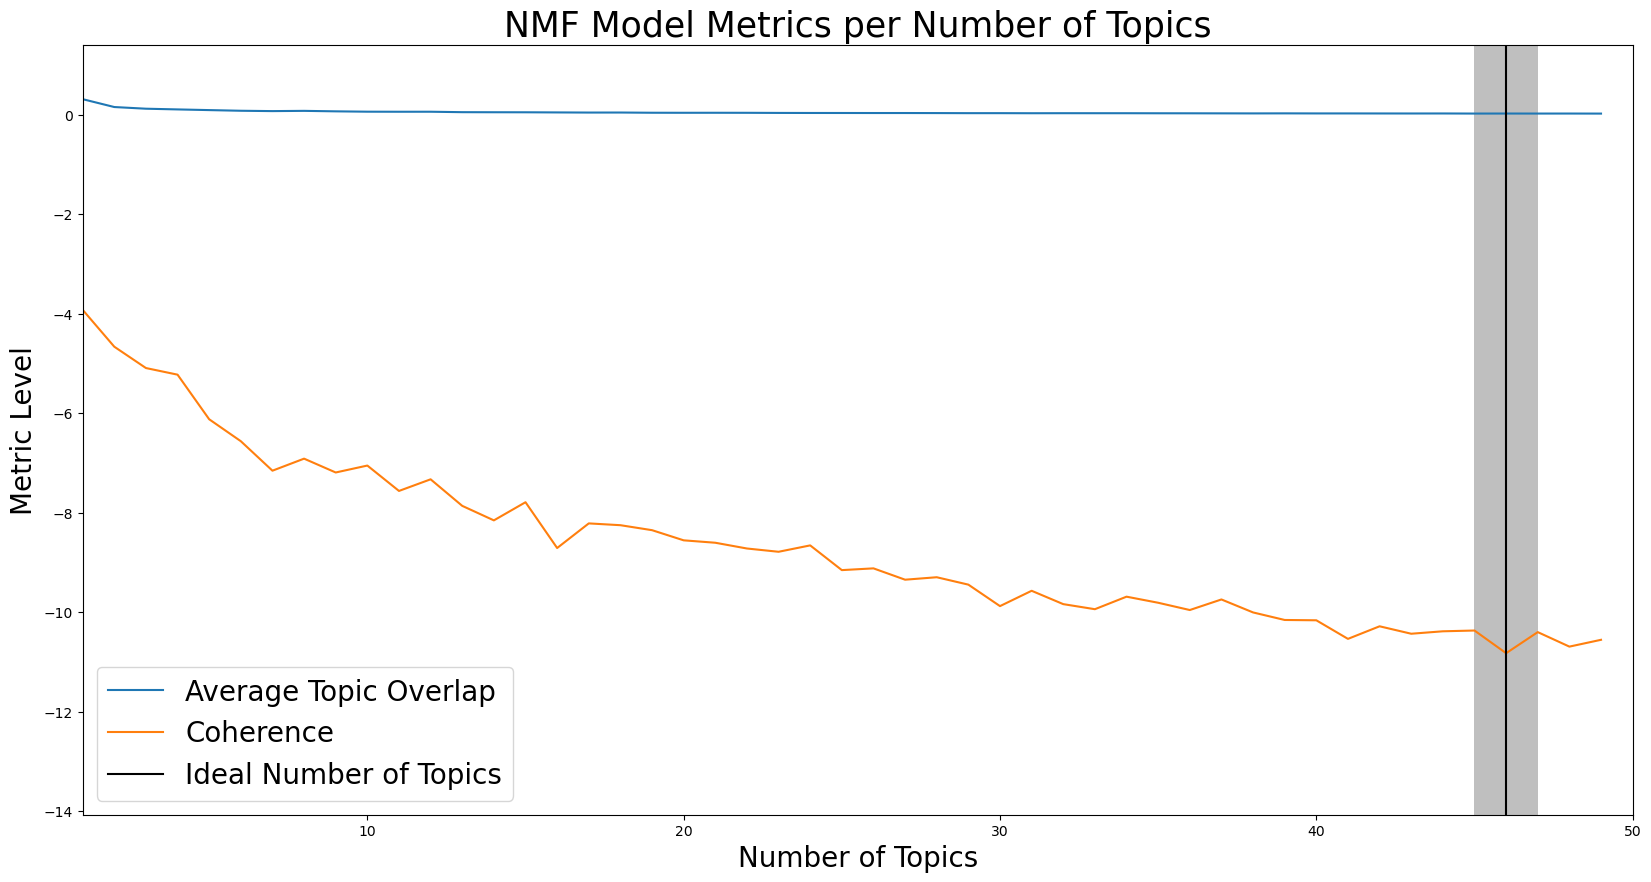

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics_list[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics_list[:-1], y=coherence_nmf_list[:-1], label='Coherence')
# ax = sns.lineplot(x=num_topics_list[:-1], y=perplexity_nmf_list[:-1], label='Perplexity')

ax.axvline(x=ideal_topic_num-1, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 2, xmax=ideal_topic_num, alpha=0.5, facecolor='grey')

y_min = min(min(mean_stabilities), min(coherence_nmf_list[:-1]))* 1.3
y_max = max(max(mean_stabilities), max(coherence_nmf_list[:-1]))* 1.3 + 1
ax.set_ylim([y_min, y_max])
ax.set_xlim([1, num_topics_list[-1]])
                
ax.axes.set_title('NMF Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [123]:
list_tmp = [(index, topic) for index, topic in enumerate(nmf_topics[ideal_topic_num])]
for index, topic in list_tmp:
    print ('Topic: {} \nTopics: {}'.format(index, topic[:]))

Topic: 0 
Topics: ['special', 'stand', 'events', 'police', 'first', 'journey', 'true', 'forces', 'loves', 'stories', 'inspired', 'comic', 'leads', 'comedy', 'marry']
Topic: 1 
Topics: ['drug', 'true', 'based', 'story', 'small', 'film', 'town', 'big', 'struggles', 'teen', 'interviews', 'powerful', 'evil', 'century', 'th']
Topic: 2 
Topics: ['based', 'face', 'relationship', 'returns', 'work', 'challenges', 'true', 'christmas', 'india', 'story', 'events', 'survive', 'comes', 'trying', 'marriage']
Topic: 3 
Topics: ['evil', 'marriage', 'work', 'special', 'stop', 'save', 'writer', 'day', 'pop', 'earth', 'stage', 'first', 'powers', 'takes', 'planet']
Topic: 4 
Topics: ['city', 'york', 'way', 'big', 'local', 'competition', 'moves', 'mexico', 'future', 'self', 'business', 'along', 'around', 'puts', 'dancer']
Topic: 5 
Topics: ['murder', 'heart', 'students', 'real', 'job', 'law', 'revenge', 'sets', 'quest', 'justice', 'sister', 'government', 'sent', 'case', 'prove']
Topic: 6 
Topics: ['falls', 

## BTM


In [186]:
import bitermplus as btm
from gensim import interfaces, utils, matutils
from gensim.matutils import (
    kullback_leibler, hellinger, jaccard_distance, jensen_shannon,
    dirichlet_expectation, logsumexp, mean_absolute_difference,
)

import tmplot as tmp

texts_list = []
for word in texts:
    texts_list.append((' ').join(word))
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts_list)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts_list, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)


In [203]:
btm_models = {}
btm_topics = {}
coherence_btm_list = []
perplexity_btm_list = []
entropy_btm_list = []
phi_list = {}

for num_topics in num_topics_list:
    # Build NMF model
    model = btm.BTM(X, vocabulary, T=num_topics)
    btm_models[num_topics] = model
    model.fit(biterms, iterations = 15)
    p_zd = model.transform(docs_vec)
    perplexity = model.perplexity_
    coherence = model.coherence_
    coherence_btm_list.append(np.average(coherence))
    perplexity_btm_list.append(perplexity)
    entropy = btm.entropy(model.matrix_topics_words_)
    entropy_btm_list.append(entropy)
    phi_list[num_topics] = tmp.get_phi(model)
    print('num_topics:', num_topics, 'Coherence btm:', coherence_btm_list[num_topics - 1], 'Perplexity btm:', perplexity_btm_list[num_topics - 1], "Entropy btm:", entropy_btm_list[num_topics - 1])
    


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 161640.57it/s]


num_topics: 1 Coherence btm: -697.943195225338 Perplexity btm: 5929.814594529451 Entropy btm: 1.9239445311509153


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 148386.10it/s]


num_topics: 2 Coherence btm: -705.0968587990199 Perplexity btm: 5325.797161441931 Entropy btm: 4.51571258551479


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 146036.05it/s]


num_topics: 3 Coherence btm: -696.2379024432597 Perplexity btm: 4993.75220870147 Entropy btm: 3.5273196910546347


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 141801.83it/s]


num_topics: 4 Coherence btm: -689.0047550862791 Perplexity btm: 4563.361834140656 Entropy btm: 3.147753877506475


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 131183.25it/s]


num_topics: 5 Coherence btm: -714.2199595261106 Perplexity btm: 4364.023335388006 Entropy btm: 3.064464567285628


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 133080.31it/s]


num_topics: 6 Coherence btm: -699.1593274913284 Perplexity btm: 4174.541881309912 Entropy btm: 2.7950234560683738


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 105105.54it/s]


num_topics: 7 Coherence btm: -697.8666429390479 Perplexity btm: 3982.457665099064 Entropy btm: 2.6708700659438644


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 121072.95it/s]


num_topics: 8 Coherence btm: -700.7322678509952 Perplexity btm: 3871.908055618335 Entropy btm: 2.6752046702261394


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 112519.45it/s]


num_topics: 9 Coherence btm: -700.58182042553 Perplexity btm: 3695.3521681213006 Entropy btm: 2.6971379468478465


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 111319.09it/s]


num_topics: 10 Coherence btm: -694.2302762287326 Perplexity btm: 3564.424549049155 Entropy btm: 2.739463055769713


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 101113.63it/s]


num_topics: 11 Coherence btm: -695.2180621554935 Perplexity btm: 3447.9831539153092 Entropy btm: 2.794287062215847


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 106389.05it/s]


num_topics: 12 Coherence btm: -703.7207152876696 Perplexity btm: 3366.164600011584 Entropy btm: 2.8413747632384916


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 103533.89it/s]


num_topics: 13 Coherence btm: -706.0746686942255 Perplexity btm: 3298.6153121781485 Entropy btm: 2.893361840745376


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 93797.97it/s]


num_topics: 14 Coherence btm: -703.7663227039257 Perplexity btm: 3177.6395833533984 Entropy btm: 2.9393624802291543


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 92927.26it/s]


num_topics: 15 Coherence btm: -708.4785670302483 Perplexity btm: 3112.990783615302 Entropy btm: 2.98587455132671


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 88160.68it/s]


num_topics: 16 Coherence btm: -707.398398035381 Perplexity btm: 3083.5282766846003 Entropy btm: 3.0381874542203895


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 77181.85it/s]


num_topics: 17 Coherence btm: -711.8269432228637 Perplexity btm: 3019.862603135956 Entropy btm: 3.0850864734371912


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 81676.45it/s]


num_topics: 18 Coherence btm: -708.1737978680204 Perplexity btm: 2944.040029793743 Entropy btm: 3.1295856217722697


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 81766.66it/s]


num_topics: 19 Coherence btm: -708.1742456930529 Perplexity btm: 2889.1085454173776 Entropy btm: 3.172314275321769


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 63566.03it/s]


num_topics: 20 Coherence btm: -702.1741627703716 Perplexity btm: 2815.340784622023 Entropy btm: 3.2146304439206843


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 74770.48it/s]


num_topics: 21 Coherence btm: -703.4351337601238 Perplexity btm: 2766.7299742424784 Entropy btm: 3.2548264068478163


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 61761.59it/s]


num_topics: 22 Coherence btm: -708.2192171005634 Perplexity btm: 2727.93875206063 Entropy btm: 3.2939406910805733


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 67200.73it/s]


num_topics: 23 Coherence btm: -707.7313798825857 Perplexity btm: 2660.2373983750367 Entropy btm: 3.33179433385852


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 70862.02it/s]


num_topics: 24 Coherence btm: -708.5707972079775 Perplexity btm: 2628.6521979839113 Entropy btm: 3.367663484686174


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 51077.84it/s]


num_topics: 25 Coherence btm: -712.0031213860134 Perplexity btm: 2597.066210771271 Entropy btm: 3.4029409850928247


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 63476.67it/s]


num_topics: 26 Coherence btm: -710.0373917797502 Perplexity btm: 2569.642583966993 Entropy btm: 3.436513550594091


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 62216.59it/s]


num_topics: 27 Coherence btm: -712.7820270732138 Perplexity btm: 2520.8101215372217 Entropy btm: 3.4690892802535283


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 59918.53it/s]


num_topics: 28 Coherence btm: -712.1674461519241 Perplexity btm: 2482.36792762361 Entropy btm: 3.5005654799109296


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 56520.73it/s]


num_topics: 29 Coherence btm: -715.1134215884556 Perplexity btm: 2465.718247487874 Entropy btm: 3.531304877323025


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 49649.38it/s]


num_topics: 30 Coherence btm: -707.6470075367938 Perplexity btm: 2429.2195925659275 Entropy btm: 3.5612488872076393


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 57547.79it/s]


num_topics: 31 Coherence btm: -711.0058581541497 Perplexity btm: 2381.598171350175 Entropy btm: 3.5897699378255825


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 52548.66it/s]


num_topics: 32 Coherence btm: -708.4287751235349 Perplexity btm: 2338.2901478882404 Entropy btm: 3.6175949397464104


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 49433.44it/s]


num_topics: 33 Coherence btm: -714.2282781624216 Perplexity btm: 2315.5389585757557 Entropy btm: 3.6448514198904767


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 54661.14it/s]


num_topics: 34 Coherence btm: -709.1111341021832 Perplexity btm: 2291.9366034554587 Entropy btm: 3.671328666039798


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 51933.32it/s]


num_topics: 35 Coherence btm: -714.5088923278254 Perplexity btm: 2280.8231402238553 Entropy btm: 3.6974068507378908


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 48700.25it/s]


num_topics: 36 Coherence btm: -712.9183454915377 Perplexity btm: 2246.9856446837116 Entropy btm: 3.722355816950911


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 49602.84it/s]


num_topics: 37 Coherence btm: -713.2784091313288 Perplexity btm: 2212.569460679939 Entropy btm: 3.7469360717350244


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 47727.21it/s]


num_topics: 38 Coherence btm: -710.968216570597 Perplexity btm: 2183.9633989404697 Entropy btm: 3.7704181756060655


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 48077.30it/s]


num_topics: 39 Coherence btm: -718.6660059707648 Perplexity btm: 2171.9716864461643 Entropy btm: 3.794057088054815


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 47380.77it/s]


num_topics: 40 Coherence btm: -722.4176267149498 Perplexity btm: 2144.93422689797 Entropy btm: 3.8166540805997156


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37938.15it/s]


num_topics: 41 Coherence btm: -722.8621949449168 Perplexity btm: 2113.696151278515 Entropy btm: 3.839010815781536


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 43165.87it/s]


num_topics: 42 Coherence btm: -716.5906918052393 Perplexity btm: 2111.0952697495554 Entropy btm: 3.860846333243674


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37461.60it/s]


num_topics: 43 Coherence btm: -719.8836790607091 Perplexity btm: 2074.5302719581355 Entropy btm: 3.881981505405533


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 41469.30it/s]


num_topics: 44 Coherence btm: -713.5103489521304 Perplexity btm: 2060.5897766498115 Entropy btm: 3.902944318566889


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 39960.27it/s]


num_topics: 45 Coherence btm: -717.7571342314465 Perplexity btm: 2018.454773211532 Entropy btm: 3.9231440897181007


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 40354.65it/s]


num_topics: 46 Coherence btm: -714.4337382977175 Perplexity btm: 2005.5338345241253 Entropy btm: 3.9430695309102783


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37602.20it/s]


num_topics: 47 Coherence btm: -713.6328212612322 Perplexity btm: 1995.5581588068655 Entropy btm: 3.962743518089474


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 35922.17it/s]


num_topics: 48 Coherence btm: -710.6340428921707 Perplexity btm: 1967.8454238790982 Entropy btm: 3.98187592687809


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37112.10it/s]


num_topics: 49 Coherence btm: -714.5666732826386 Perplexity btm: 1958.2839277568823 Entropy btm: 4.000870132561867


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37275.16it/s]


num_topics: 50 Coherence btm: -715.7037313837095 Perplexity btm: 1922.6998476509052 Entropy btm: 4.019153549690079


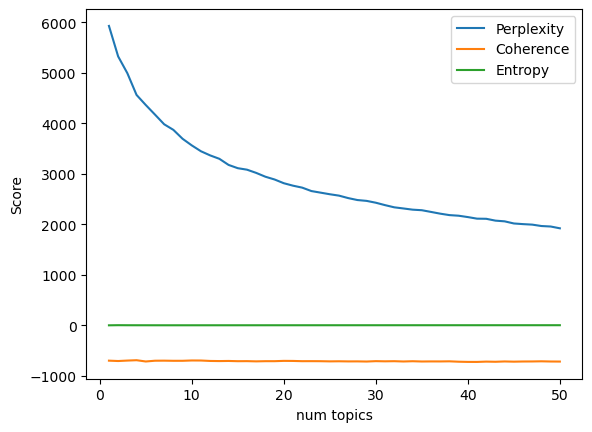

In [204]:
plt.plot(num_topics_list, perplexity_btm_list, label='Perplexity')
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
plt.plot(num_topics_list, entropy_btm_list, label='Entropy')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.legend()
plt.show()

In [205]:
plt.plot(num_topics_list, perplexity_btm_list, label='Perplexity')
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
# plt.plot(num_topics_list, entropy_btm_list, label='Entropy')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.title('BTM Model Metrics per Number of Topics')
plt.legend()
plt.show()

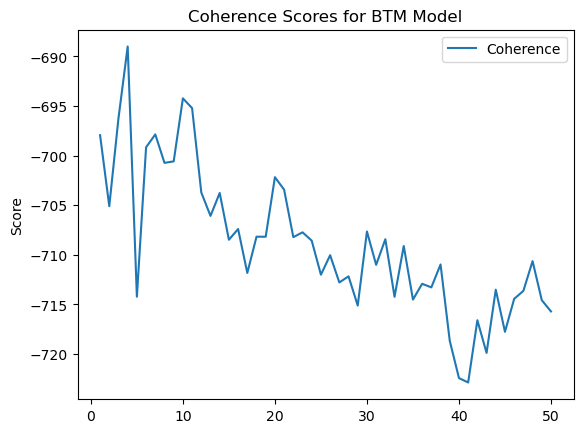

In [206]:
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
plt.ylabel('Score')
plt.title('Coherence Scores for BTM Model')
plt.legend()
plt.show()

In [207]:
max_coherence = max(coherence_btm_list)
index = coherence_btm_list.index(max(coherence_btm_list))
print(max_coherence, " at topic number = ", index+1)

-689.0047550862791  at topic number =  4


In [208]:
topic_num = 4
phi = phi_list[topic_num]

for i in phi.columns:
  top_words = phi.sort_values(by=i, ascending = False).head(num_keywords).index.tolist()
  word_results = ", ".join(top_words) 
  print(f"Topic {i}: {word_results}")

Topic 0: stand, documentary, special, comedy, show, comedian, takes, film, star, stories, music, take, old, comic, stage
Topic 1: documentary, save, find, team, day, time, fight, war, city, story, take, group, true, big, evil
Topic 2: find, old, years, murder, year, group, war, back, police, son, takes, town, crime, daughter, true
Topic 3: girl, daughter, teen, student, find, old, becomes, gets, soon, back, town, son, takes, past, wife


In [209]:
texts = [" ".join(i) for i in data_words]
btm.get_top_topic_docs(texts, btm_models[topic_num].matrix_docs_topics_, num_keywords)

topic0  \
0   comedians mariusz kałamaga karol kopiec wiolka...   
1   milos knor brings comedians lukas pavlasek tom...   
2   recipe star rafał rutkowski comedy lab olka sz...   
3   polish comedians rafał paczes katarzyna piasec...   
4   argentina luciano mellera emphasizes humorous ...   
5   comedians steve harvey cedric entertainer dl h...   
6   mike birbiglia performs concert special featur...   
7   charismatic comedy pals karol modzelewski łuka...   
8   chile natalia valdebenito hits santiago teatro...   
9   writer actor satirist tomasz jachimek teams co...   
10  jerry seinfeld leslie jones kevin hart hannah ...   
11  irreverent sitcom featues ludovico federica ch...   
12  teams compete navigate rooms flooded lava leap...   
13  polish comedians rafał banas michał leja prese...   
14  youtube sensation felipe neto brings stories b...   

                                               topic1  \
0   kari byron tory belleci grant imahara rank his...   
1   thracian condemned brutal death arena outlast ...   
2   hazardous highways canada interior heavy vehic...   
3   lazy lasagna loving fat cat garfield terms inc...   
4   dessert wizard adriano zumbo looks next willy ...   
5   australia toughest big rig drivers brave wildf...   
6   lorena ramirez mexico raramuri community pasto...   
7   songstress sisters toni traci towanda trina ta...   
8   owned operated hotspot ink harlem tattoo king ...   
9   heirless maharaj brajbhan leaves throne cousin...   
10  depth look full cycle breeding program bluefin...   
11  nonsense logger loyal crew battle brutal eleme...   
12  ikoma iron fortress take fight battlegrounds u...   
13  years yugo team defeat qilby ogrest crying flo...   
14  greedy captain fishbeard stealing everybody ha...   

                                               topic2  \
0   blind librarian dispirited cricketer desolate ...   
1   blind librarian dispirited cricketer desolate ...   
2   fred armisen carrie brownstein send residents ...   
3   mind fogged scimitar weilding stranger mayuri ...   
4   dragons menu crew airship quin zaza sets hunt ...   
5   outcast descendant lawman wyatt earp teams imm...   
6      detective interrogates monkey suspected murder   
7   mistakenly accused attack fourth raikage ninja...   
8   mistakenly accused attack fourth raikage ninja...   
9   year eric draven fiancee murdered draven watch...   
10  depression era orleans cocksure stud poker pla...   
11  diagnosed multiple sclerosis responds training...   
12  directors emmy nominated lust stories zoya akh...   
13  subterranean worm like creatures back graboid ...   
14  plot bait snake goddess nagin immortality gran...   

                                               topic3  
0   lifting saggy skin repairing shoddy breast enh...  
1   upping cameras ante sequel renting vacation ho...  
2   hailing mountains iga kanzo hattori moves elem...  
3   wake jesus christ crucifixion apostles dedicat...  
4   gigi avant garde french waif groomed fille de ...  
5   gab eager tie knot handsome boyfriend problem ...  
6   tasked unraveling assassination archduke franz...  
7   schooler ayumi perfect evaporates envious clas...  
8   determined athenian attorneys spearhead lawsui...  
9   schooler haruna befriends loner yamada drawn t...  
10  blindsided boyfriend prove fidelity girlfriend...  
11  spunky lower caste lad jabya falls lovely uppe...  
12  fearless dennis loyal dog gnasher best rubi jj...  
13  dedicated pediatrician reconsiders feelings ca...  
14  continents face crisis disciple joins spirit b...

## CorEx

In [227]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline


In [228]:
vect = CountVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1,1), min_df = 0.01)
X = vect.fit_transform([" ".join(i) for i in data_words])
X = ss.csr_matrix(X)


### CorEx without anchor words

In [68]:
corex_models = {}
coherence_corex_list = []
perplexity_corex_list = []

for num_topics in num_topics_list:
    # Build CorEx model
    model = ct.Corex(n_hidden=num_topics, verbose = False)
    corex_models[num_topics] = model
    
    words = vect.get_feature_names()
    model.fit(X, words = words, anchors=None)
    
    coherence_corex_list.append(model.tc)
    
    print('num_topics:', num_topics, 'CorEx Total Coherence:', coherence_corex_list[num_topics - 1])
    

num_topics: 1 CorEx Total Coherence: 0.12183667149174388
num_topics: 2 CorEx Total Coherence: 0.1251966061070424
num_topics: 3 CorEx Total Coherence: 0.16379272880263424
num_topics: 4 CorEx Total Coherence: 0.17317362290873545
num_topics: 5 CorEx Total Coherence: 0.16391999531327958
num_topics: 6 CorEx Total Coherence: 0.21394227988137046
num_topics: 7 CorEx Total Coherence: 0.18667055186496767
num_topics: 8 CorEx Total Coherence: 0.17630551185292548
num_topics: 9 CorEx Total Coherence: 0.25262273047380196
num_topics: 10 CorEx Total Coherence: 0.19291675729154723
num_topics: 11 CorEx Total Coherence: 0.21917944222445587
num_topics: 12 CorEx Total Coherence: 0.23502054973075712
num_topics: 13 CorEx Total Coherence: 0.22139630523450515
num_topics: 14 CorEx Total Coherence: 0.21140781078443785
num_topics: 15 CorEx Total Coherence: 0.2190354919984069
num_topics: 16 CorEx Total Coherence: 0.2536950762028687
num_topics: 17 CorEx Total Coherence: 0.21882762024765554
num_topics: 18 CorEx Total

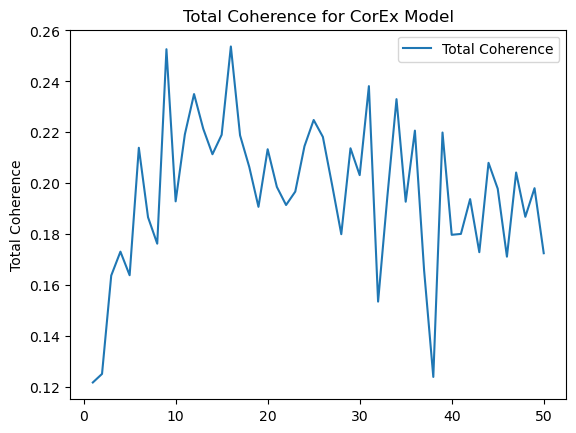

In [128]:
plt.plot(num_topics_list, coherence_corex_list, label='Total Coherence')
plt.ylabel('Total Coherence')
plt.title('Total Coherence for CorEx Model')
plt.legend()
plt.show()

In [129]:
max_coherence = max(coherence_corex_list)
index = coherence_corex_list.index(max_coherence)
print(max_coherence, " at topic number = ", index+1)

0.2536950762028687  at topic number =  16


In [131]:
topic_num = 16
corex_topics = corex_models[topic_num].get_topics()
for topic_idx,topic in enumerate(corex_topics):
#     topic = [w if s > 0 else ('~'+w) for w,_,s in topic]
    topic = [w for w,_,s in topic]
    results = ", ".join(topic[:num_keywords])
    print(f"Topic {topic_idx}: {results}")

Topic 0: stand, special, comedian, comedy, comic, night, sex, star, death, become
Topic 1: true, story, based, events, real, drama, crime, drug, dangerous
Topic 2: old, year, war
Topic 3: town, small, girl, social
Topic 4: back, together, win, time, try, kids, personal, way, find, chance
Topic 5: city, york, big, around, adventure, years
Topic 6: documentary, follows, film, career, returns, look, secrets, dark, job, crew
Topic 7: daughter, wife, son, husband, goes, child, marriage, history, falls, begins
Topic 8: police, cop, detective, killer, different, leads, best
Topic 9: secret, brother, agent, revenge, discovers, sets, ex, soon, former, may
Topic 10: student, couple, college, relationship, wealthy, romance, meets, single, team, living
Topic 11: fight, evil, earth, forces, students, power, group, self, discover, go
Topic 12: takes, turn, india, come, dreams, journey, whose, business
Topic 13: stories, people, women, men, teen, turns, childhood, band, first
Topic 14: show, game, vi

### CorEx with anchor_words

In [272]:
corex_models2 = {}
coherence_corex_list2 = []
perplexity_corex_list2 = []
anchor_words = ['documentary', 'comedy', 'crime', 'romance', 'music', 'history', 'war']
num_anchor_words = len(anchor_words)
for num_topics in num_topics_list[num_anchor_words-1:]:
    # Build CorEx model
    model2 = ct.Corex(n_hidden=num_topics, verbose = False)
    corex_models2[num_topics] = model2
    
    words = vect.get_feature_names()
    model2.fit(X, words = words, anchors=anchor_words, anchor_strength=2)
    
    coherence_corex_list2.append(model2.tc)
    
    print('num_topics:', num_topics, 'CorEx Total Coherence:', coherence_corex_list2[num_topics - num_anchor_words])

num_topics: 7 CorEx Total Coherence: 0.7883462602518541
num_topics: 8 CorEx Total Coherence: 0.829250335741227
num_topics: 9 CorEx Total Coherence: 0.844402739433516
num_topics: 10 CorEx Total Coherence: 0.8554995761412534
num_topics: 11 CorEx Total Coherence: 0.8499826197770541
num_topics: 12 CorEx Total Coherence: 0.8269103241438737
num_topics: 13 CorEx Total Coherence: 0.8491447952611554
num_topics: 14 CorEx Total Coherence: 0.8676737064711297
num_topics: 15 CorEx Total Coherence: 0.8675876134727919
num_topics: 16 CorEx Total Coherence: 0.8680657634517898
num_topics: 17 CorEx Total Coherence: 0.8788066167342728
num_topics: 18 CorEx Total Coherence: 0.8776956952345927
num_topics: 19 CorEx Total Coherence: 0.8720330527785084
num_topics: 20 CorEx Total Coherence: 0.917850490201116
num_topics: 21 CorEx Total Coherence: 0.8797251379053896
num_topics: 22 CorEx Total Coherence: 0.8695328828244615
num_topics: 23 CorEx Total Coherence: 0.865307610498742
num_topics: 24 CorEx Total Coherence: 

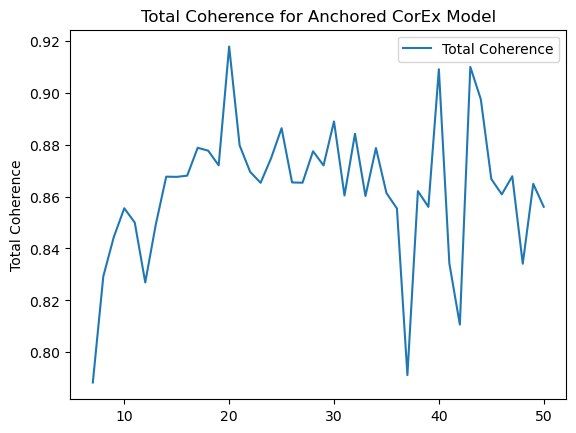

In [273]:
plt.plot(num_topics_list[num_anchor_words-1:], coherence_corex_list2, label='Total Coherence')
plt.ylabel('Total Coherence')
plt.title('Total Coherence for Anchored CorEx Model')
plt.legend()
plt.show()

In [274]:
max_coherence = max(coherence_corex_list2)
index = coherence_corex_list2.index(max_coherence)
print(max_coherence, " at topic number = ", index+num_anchor_words)

0.917850490201116  at topic number =  20


In [275]:
topic_num = index+num_anchor_words
corex_topics = corex_models2[topic_num].get_topics()
for topic_idx,topic in enumerate(corex_topics):
#     topic = [w if s > 0 else ('~'+w) for w,_,s in topic]
    topic = [w for w,_,s in topic]
    results = ", ".join(topic[:num_keywords])
    print(f"Topic {topic_idx}: {results}")

Topic 0: documentary, follows, us, find, returns, begins, son, marriage, keep, american
Topic 1: comedy, stand, special, comedian, comic, show, night, sex, student, fight
Topic 2: crime, cop, murder, drug, group, human, single
Topic 3: romance, relationship, together, living
Topic 4: music, star, band, children
Topic 5: history, future, way
Topic 6: war, sister, discover
Topic 7: city, turn, york, big, trip, takes, take, around, years, face
Topic 8: make, dreams, come
Topic 9: true, story, based, events, real, teen, whose, work, long
Topic 10: old, year, past, students
Topic 11: evil, mission, forces, power, crew, powerful, business, look, battle, become
Topic 12: girl, mysterious, sets, village, stories, meets, run, reality
Topic 13: back, win, kids, gets, chance, parents, people, heart, girlfriend, behind
Topic 14: soon, dark, drama, earth, film, india, secret, journey, women, discovers
Topic 15: wife, daughter, husband, becomes, adventure, fun, ex, falls, revenge, best
Topic 16: tea

# Thematic Analysis (Using Anchored CorEx Model)

In [300]:
for topic_num in range(0, 20):
    print(topic_num)
    top_docs = corex_models2[20].get_top_docs(topic=topic_num, n_docs=5, sort_by='log_prob')
    for doc, prob in top_docs:
        print(data['description'][doc])
    print()

0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
This intense documentary follows real cases of American girls enslaved in the child sex trade through ads in a newspaper's online classified section.
This fun, charming documentary follows the exploits of some very feline-friendly folks as they strive to get their kitties crowned Canada’s top cat.
This documentary follows three women – a fire chief, a judge and a street missionary – as they battle West Virginia's devastating opioid epidemic.
Harry Dean Stanton narrates this documentary that follows two modern-day cowboys as they welcome new calves at Montana's Fishtail Basin Ranch.
This comic documentary follows the Mortified movement, a series of stage events where adults share awkward childhood moments in front of strangers.

1
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
"Last Comic Standing" winner Felipe Esparza runs riot in his first comedy special with his wry comme